#### Task 1:  

Вы провели эксперимент c упрощением формы заказа в магазине Утконос и получили результаты по метрике конверсий в покупку. Выберите метод оценки и оцените есть ли стат. значимые различия между конверсиями в двух группах при alpha = 5%. Дайте краткие рекомендации команде.

Результаты: 
- Число юзеров в группах , которые заходили на сайт в период эксперимента: n1 = 15550 и n2 = 15550 
- Число юзеров в группах , которые совершили хотя бы одну покупку за период эксперимента: n1 = 164 и n2 = 228 
- Конверсии : conv1 = 1.05% conv2 = 1.47%

#### Task 2:
Сравниваем метрику конверсия в покупку. Размер выборки - 10000 элементов в каждой группе. Какой статистический критерий тут лучше всего подойдёт и почему?

In [1]:
# packages imports
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

## Task 1 

In [3]:
# conditions of the task
alpha = 0.05 # threshold for confidence level
n_initial = 15550 # initial number of users
n1_final = 164 # number of users with purchase (group 1)
n2_final = 228 # number of users with purchase (group 2)
conv1 = 0.0105 # conversion rate (group 1)
conv2 = 0.0147 # conversion rate (group 2)

In [4]:
# calculate effect size based on expected rates
effect_size = sms.proportion_effectsize(conv1, conv2)

In [8]:
# calculate sample size needed
required_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8, 
    alpha=alpha, 
    ratio=1
)                                        

In [9]:
# round up to next whole number and print out observations 
required_n = ceil(required_n)                                               
print(f'Minimum number of observations for each group: {required_n}')

Minimum number of observations for each group: 10995


In [14]:
# create the pandas DataFrame
df = pd.DataFrame(
    [['group 1', conv1], ['group 2', conv2]], 
    columns=['group', 'conversion']
)
display(df)

,group,conversion
0,group 1,0.0105
1,group 2,0.0147


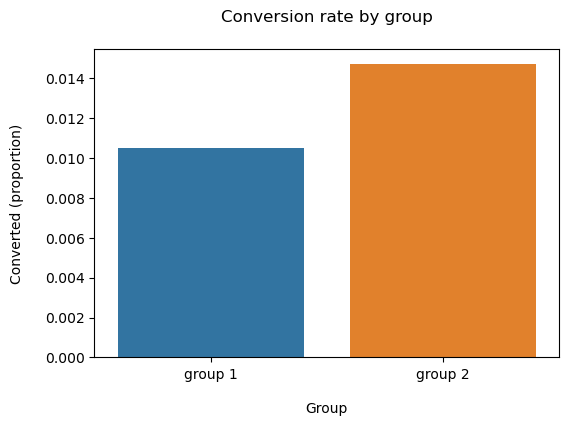

In [17]:
# print out conversion rates for each group
plt.figure(figsize=(6,4))
sns.barplot(x=df['group'], y=df['conversion'])

plt.title('Conversion rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15);

The conversion rates for the groups are indeed very close. Also note that the conversion rate of the control group 1 is lower than tne treatment group 2, so that more users make some purchases after treatment.

The addition between standard deviations obeys the concept of:

Var(X+Y) = Var(X) + Var(Y) if X and Y are independent.

In [23]:
# find stats params of group 1 and group 2 for A/B test
lift = -abs(conv1 - conv2) # difference between the conversion rates
scale_one = conv1 * (1 - conv1) * (1 / n_initial) # variance for group 1
scale_two = conv2 * (1 - conv2) * (1 / n_initial) # variance for group 2
scale_val = (scale_one + scale_two) ** 0.5 # standard deviation

In [27]:
# calculate p-value
p_value = 2 * stats.norm.cdf(lift, loc=0, scale=scale_val)
print(f'P-value: {round(p_value, 7)}')

P-value: 0.0008976


The function stats.norm.cdf returns the probability of "lift being close to zero" if lift is supposed to be "normal". If lift is zero, then there is no difference between groups, so a p-value of <0.05 tell us that the probability that the groups are equal is almost 0, meaning that your groups are different.

In [26]:
# H0 => µ1 = µ2 (population mean of group 1 is equal to group 2)
# HA => µ1 ≠ µ2 (population mean of group 1 is different from group 2)
if (p_value < alpha):
    print('Reject Null Hypothesis\n')
else:
    print('Fail to Reject Null Hypothesis\n')

Reject Null Hypothesis



## Task 2

Based on proportion effect size calculated above (with statistical power=0.8), the output is pretty self-explanatory: 

This is telling us that we need at least 10995 observations in both test and control to be able to detect an increase of at least +0.42% in our metric. 10000 observations are not enough.

Due to the fact that standard deviation is not known and size of dataset is pretty large, t-test has to be used.